# Graph network code for Jodie

In [172]:
# import pandas as pd
# import numpy as np
# import json

# df = pd.read_csv('./data/aruba/aruba.csv')

# with open('./data/aruba/aruba.json') as f:

#     jsonfile = json.load(f)

# # jsonfile


# print((df.values.shape))



# config = {"config": [

#     {"name": "Meal_Preparation", "id": 0},
#     {"name": "Relax", "id": 1},
#     {"name": "Eating", "id": 2},
#     {"name": "Work", "id": 3},
#     {"name": "Sleeping", "id": 4},
#     {"name": "Wash_Dishes", "id": 5},
#     {"name": "Bed_to_Toilet", "id": 6},
#     {"name": "Enter_Home", "id": 7},
#     {"name": "Leave_Home", "id": 8},
#     {"name": "Housekeeping", "id": 9},
#     {"name": "Respirate", "id": 10},
#     {"name": "Idle", "id": 11}
# ]
# }

# # for all the values that are 1 in the sensor
# # user_id = room_id (json)
# # item_id = sensor_id(json)
# # comma_separated_list_of_features = [SensorType(json), Spos(json), value(csv), time_of_the__day(csv), rtype, room_location ]
# # state_label = activity (from csv for that row)

# columns = df.columns[4:]
# rows = []
# for i, row in enumerate(df.values):

#     if i == 100:
#         break
#         # get names of column where value is 1
#     sensor_True_Col = np.nonzero(row[4:] == 1)[0]
#     if sensor_True_Col.size != 0:
#         # print(i)
#         for val in sensor_True_Col:
#             # print(columns[val])
#             sensorName = columns[val]
#             # print(row)
#             row_rBedPressureRightoom = [row_room for row_room in jsonfile['rooms_location'] if sensorName in row_room['sensorsInRoom']][
#                 0]
#             user_id = row_room['id']

#             row_sensor = [[row_sensor['id'], row_sensor['location'], row_sensor['name']] for row_sensor in
#                           jsonfile['sensor_location'] if row_sensor['name'] == sensorName]
#             item_id = row_sensor[0][0]
#             row_sensor_name = row_sensor[0][2]
#             sensor_type = [155 if row_sensor_name.startswith('D') else 13][0]
#             sensorPosition = row_sensor[0][1]
#             value = 1
#             timestamp = row[3]
#             state_label = [className['id'] for className in config['config'] if className['name'] == row[2]][0]
#             comma_separated_list_of_features = np.array(
#                 [sensor_type, sensorPosition[0], sensorPosition[1], value, timestamp, row_room['id'],
#                  ])

#             B = np.copy(np.array([user_id, item_id, timestamp, state_label, comma_separated_list_of_features]))
#             rows.append(B)

#     else:
#         state_label = [className['id'] for className in config['config'] if className['name'] == row[2]][0]
#         rows.append(np.array(
#             [user_id, item_id, row[3], state_label, np.array([sensor_type, sensorPosition[0], sensorPosition[1], 0, row_room['id']])]))

# wikiDataFrame = pd.DataFrame(rows, columns=['user_id', 'item_id', 'timestamp', 'state_label',
#                                             'comma_separated_list_of_features'])

# wikiDataFrame.to_csv('wikipedia.csv')





# Make Master CSV

In [6]:
import pandas as pd
import numpy as np
import json


houseC = pd.read_csv('../../data/master/houseC.csv')
ordonezB = pd.read_csv('../../data/master/ordonezB.csv')

with open('../../data/master/master.json') as f:

    masterJson = json.load(f)

In [3]:
df = pd.DataFrame( )
for key in masterJson.keys():
        
    currentCSV = key + '.csv'
    currentCSV = pd.read_csv('./data/master/' + currentCSV)
    temp = currentCSV[['start', 'end', 'activity', 'time_of_the_day']].copy()
    
    for dictionary in masterJson[key]:
        genericColumn = list(dictionary.keys())[0]            
        specificColumn = dictionary[genericColumn][0]['name']            
        temp[genericColumn] = currentCSV[specificColumn]
    df = pd.concat([df, temp])    
    df = df.fillna(-1)
    df.iloc[:,4:] = df[df.columns[4:]].apply(pd.to_numeric, downcast='integer')    

    
# df.to_csv('../Research/data/master/master.csv', index=False)

BedPressureRight
BasinBathroomPIR
ToiletFlushSensor
ShowerBathroomPIR
FridgeMagnetic
GroceriesCupboard
Microwave
ToiletSeatPressureSensor
FrontDoorMagnetic
LivingRoomDoorPIR
KitchenRoomDoorPIR
BedRoomDoorPIR


# Getting Unique activities in CSV's


In [196]:
!pwd

/home/harsh/Downloads/Thesis/Graph/dgl/related_code/3-basics


# Making Nodes and Edges for graph through house json file

In [6]:
!pwd
import os
import json
import pandas as pd
import numpy as np
import json

file_names = ['houseA','houseB','houseC','ordonezA','ordonezB']

for file_name in file_names:
    
    json_file_name = file_name + '.json'
    csv_file_name = file_name + '.csv'
    
    json_file = os.path.join('../../data', file_name, json_file_name )
    csv_file = os.path.join('../../data', file_name, csv_file_name)

        
    with open(json_file) as f:
        json_file = json.load(f)


    csv_file = pd.read_csv(csv_file)

    locations = json_file['locations']

    sensors = json_file['sensors']

    def sensor_place_in_house_ID(col_name, location_id = 1):
        # Find sensor dict and take the location key, whose name matches with col names        
        location_id = [x['location'] for x in sensors if x['name'] == col_name][0]            
        if len(location_id) == 1:
            location_type = [x['type'] for x in locations if x['id'] == location_id[0]][0]
            return [rooms.index(location_type)]
        else:
            items =[]
            for item in location_id:
                location_type = [x['type'] for x in locations if x['id'] == item][0]        
                items.append(rooms.index(location_type))
            return items


    # get rooms as nodes first, by giving them id and make a dictionary of their features
    nodes_dictionary_list = []
    d = {}

    rooms = [name['type'] for name in locations]
    count  = 0
    # convert it into a dictionary list
    for i, node in enumerate(rooms):
        d = {}
        d['Id'] = count
        d['Object'] = node
        d['Value'] = -1
        d['place_in_house'] = count
        d['Type'] = 1
        count+= 1
        nodes_dictionary_list.append(d)


    # csv column names
    col = list(csv_file.columns[4:].values)
    
    for i, col_name in enumerate(col):
        Id = i
        Object = col_name.split('_')[0]
        Value = -1            
        place_in_house = sensor_place_in_house_ID(Object)
        Type = 0

        # Append to nodes_dictionary_list 

        for location_id in place_in_house:
            d = {}        
            d['Id'] = len(nodes_dictionary_list)
            d['Object'] = Object
            d['Value'] = -1    
            d['Type'] = 0    
            d['place_in_house'] = location_id        
            nodes_dictionary_list.append(d)

    # Adding time of the day as the last node

    d ={}
    d['Id'] = len(nodes_dictionary_list)
    d['Object'] = 'time_of_the_day'
    d['Value'] = -1    
    d['Type'] = -1    
    d['place_in_house'] = -1        

    nodes_dictionary_list.append(d)

    # print(list(nodes_dictionary_list))

    import csv

    toCSV = nodes_dictionary_list



    # json_file = os.path.join('../../data', file_name)


    keys = toCSV[0].keys()
    with open(os.path.join('../../data', file_name, 'nodes.csv'), 'w', newline='')  as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(toCSV)



    # Write Edge.csv

    # Make a list of src and destination and write it via pandas
    Src = []
    Dst = []
    for node_dict in nodes_dictionary_list:
        if node_dict['Type'] == 0:
            # Birectional Edges
            Src.append(node_dict['Id'])
            Dst.append(node_dict['place_in_house'])

            Src.append(node_dict['place_in_house'])
            Dst.append(node_dict['Id'])


    # Connect rooms 

    for location_dict in locations:    
        src_location_id = rooms.index(location_dict['type'])

        reaches_list = location_dict['reaches']
        for reach_id in reaches_list:        
            Type = [x['type'] for x in locations if x['id'] ==  reach_id][0]
            dst_location_id = rooms.index(Type)        
            Src.append(src_location_id)
            Dst.append(dst_location_id)

    Src.append(nodes_dictionary_list[-1]['Id'])
    Dst.append(nodes_dictionary_list[-1]['Id'])

    df = pd.DataFrame({'Src' : Src,'Dst' : Dst})    
    df.to_csv(os.path.join('../../data', file_name, 'bidrectional_edges.csv'), index=False)


/home/harsh/Downloads/Thesis/Graph/dgl/related_code/3-basics


# Maping Activity 

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import json

In [297]:
# {'name': 'brushTeeth', 'id': 0}

merging_activties = {
"loadDishwasher": "washDishes",
"unloadDishwasher": "washDishes",
"loadWashingmachine": "washClothes",
"unloadWashingmachine": "washClothes",
"receiveGuest": "relaxing",
"eatDinner": "eating",
"eatBreakfast": "eating",
"getDressed": " grooming",
"shave": "grooming",
"getDressed": " grooming",
"takeMedication": "idle",
"leave_Home": "leaveHouse",
"Sleeping": "goToBed",
"Bed_to_Toilet": "useToilet",
"Enter_Home": "idle",
"Respirate": "relaxing",
"Work": "idle",
"Housekeeping": "idle",
"watchTV": "relaxing"
}

In [298]:
houseA = ['idle', 'leaveHouse', 'eating', 'useToilet', 'takeShower', 'brushTeeth', 'goToBed', 'prepareBreakfast', 'prepareDinner', 'getSnack', 'getDrink', 
    'loadDishwasher', 'unloadDishwasher', 'storeGroceries', 'loadWashingmachine', 'unloadWashingmachine', 'receiveGuest']


houseB = ['brushTeeth', 'eatBreakfast', 'eatDinner', 'getDressed', 'getDrink', 'goToBed', 'idle', 'leaveHouse', 'prepareBreakfast', 'prepareDinner', 'takeShower', 'useToilet', 'washDishes']


houseC = ['brushTeeth', 'eating', 'getDressed', 'getDrink', 'getSnack', 'goToBed', 'idle', 'leaveHouse', 'prepareBreakfast', 'prepareDinner', 'prepareLunch', 'shave', 'takeMedication', 'takeShower', 'useToilet']

#aruba = ['Bed_to_Toilet', 'Eating', 'Enter_Home', 'Housekeeping', 'Idle', 'Leave_Home', 'Meal_Preparation', 'Relax', 'Respirate', 'Sleeping', 'Wash_Dishes', 'Work']


ordonezA = ['idle', 'goToBed', 'useToilet', 'takeShower', 'prepareBreakfast', 'prepareLunch', 'grooming', 'watchTV', 'leaveHouse', 'getSnack', 'prepareDinner']

ordonezB = ['getSnack', 'goToBed', 'grooming', 'idle', 'leaveHouse', 'prepareBreakfast', 'prepareDinner', 'prepareLunch', 'takeShower', 'useToilet', 'watchTV']

In [299]:
all_houses = [houseA, houseB, houseC, ordonezA, ordonezB]
final_activity_list = []

for house in all_houses:
    for activity in house:
        try:
            mappedActivity = merging_activties[activity]
            final_activity_list.append(mappedActivity)
        except:
            final_activity_list.append(activity)
            

In [300]:
final_activity_list = [x for x in final_activity_list]

In [301]:
final_activity_list = (set(final_activity_list))

In [302]:
final_activity_list = [{"name": activity, "id":idx} for idx, activity in enumerate(final_activity_list)]

In [303]:
final_activity_list

[{'name': 'prepareDinner', 'id': 0},
 {'name': 'washDishes', 'id': 1},
 {'name': 'prepareBreakfast', 'id': 2},
 {'name': 'prepareLunch', 'id': 3},
 {'name': 'useToilet', 'id': 4},
 {'name': 'takeShower', 'id': 5},
 {'name': 'leaveHouse', 'id': 6},
 {'name': 'brushTeeth', 'id': 7},
 {'name': 'getSnack', 'id': 8},
 {'name': ' grooming', 'id': 9},
 {'name': 'getDrink', 'id': 10},
 {'name': 'goToBed', 'id': 11},
 {'name': 'eating', 'id': 12},
 {'name': 'grooming', 'id': 13},
 {'name': 'idle', 'id': 14},
 {'name': 'storeGroceries', 'id': 15},
 {'name': 'relaxing', 'id': 16},
 {'name': 'washClothes', 'id': 17}]

# Generate Benchmarking Papers' CSV, then to be passed to LSTM)

In [1]:
# (a) x <= 5
# (d) 60 < x <= 120 
# (f) 150 < x <= 660
# (b) 5 < x <= 30 
# (e) 120 < x <= 150 
# (g) x > 660
# (c) 30 < x <= 60

import pandas as pd
import numpy as np
import pandas as pd
import json

In [2]:
df = pd.read_csv('../../data/houseC/houseC.csv')

In [205]:
seq_length = 1
prev_index = 0
seq_list = []
for index, row in df[:-1].iterrows():
    
    prev_value = df.iloc[prev_index, 4:]
    prev_value = ''.join(map(str, prev_value.values))
    
    if prev_value == ''.join(map(str, df.iloc[index + 1, 4:].values)):
        seq_length += 1
    else:        
        seq_list.append(seq_length)
        seq_length = 1
        prev_index = index + 1                
    
#     if index == 1000:
#         break

# sum_list =  row to be choosen in new dataframe.
sum_list = []
for i in range(len(seq_list)):
    sum_list.append(sum(seq_list[:i + 1]) -1)
# print('final rows list  ',sum_list)

# Seq_list = unary representation for each unique
# print('seq list ',  seq_list)

truncatedDataframe = pd.DataFrame([])

for index, x in enumerate(sum_list):         
    truncatedDataframe = truncatedDataframe.append(df.iloc[sum_list[index] ,:])


# convert each value according to bin, 
bins_seq_list = np.copy(seq_list)
for i, x in enumerate(bins_seq_list):
    if x <= 5:
        bins_seq_list[i] = 1
    elif 5 < x <= 30:
        bins_seq_list[i] = 2
    elif 30 < x <= 60:
        bins_seq_list[i] = 3
    elif 60 < x <= 120:
        bins_seq_list[i] = 4
    elif 120 < x <= 150:
        bins_seq_list[i] = 5
    elif 150 < x <= 660:
        bins_seq_list[i] = 6
    elif x > 660:
        bins_seq_list[i] = 7
                


In [206]:

# convert to unary representation
final_unary_list = []

for i in range(len(bins_seq_list)):
    gn_list = 7 * [0]
    ones_list = np.ones(bins_seq_list[i], dtype = int)
    zero_list = np.zeros(7 - bins_seq_list[i], dtype = int)
    unary_list = np.append(ones_list , zero_list)
    final_unary_list.append(unary_list)
    

In [207]:
# [{"name": activity, "id":idx} for idx, activity in enumerate(pd.unique( df['activity']))]

In [208]:
truncatedDataframe['one_hot_time_of_the_day'] = round(truncatedDataframe['time_of_the_day'] * 24)
final_one_hot_time_of_day = []
for val in truncatedDataframe['one_hot_time_of_the_day']:        
    a = np.zeros(25, dtype = int)
    a[int(val)] =  1
    final_one_hot_time_of_day.append(a)


In [209]:
truncatedDataframe = truncatedDataframe.set_index(np.arange(truncatedDataframe.shape[0]))

In [210]:
# type(final_one_hot_time_of_day[0][0])

In [211]:
# truncatedDataframe['one_hot_time_of_the_day'] = final_one_hot_time_of_day

In [212]:
np.array(final_one_hot_time_of_day).shape
one_hot_time_of_the_day = pd.DataFrame(np.array(final_one_hot_time_of_day), columns=['one_hot_' + str(i) for i in range(np.array(final_one_hot_time_of_day).shape[1])])
# one_hot_time_of_the_day

In [213]:

final_unary_list = pd.DataFrame(final_unary_list, columns=['unary_' + str(i) for i in range(np.array(final_unary_list).shape[1])])

# final_unary_list



In [214]:
final_csv = pd.concat([truncatedDataframe, one_hot_time_of_the_day, final_unary_list], axis =1)


In [215]:
# Shuffling the column to restore the original order
col = final_csv.columns.values.tolist()

cols = ['start', 'end', 'activity', 'time_of_the_day']

col = [x for x in col if x not in cols]
col.insert(0, 'start')
col.insert(1, 'end')
col.insert(2, 'activity')

final_csv = final_csv[col]

In [216]:
# final_csv.iloc[:, 4:26] = final_csv.iloc[:, 4:26].apply(pd.to_numeric, downcast='integer')

In [217]:
final_csv.to_pickle('../../../../../Thesis/dummyTestforPycharm/data/houseC/one_hot.csv')

final_csv.to_csv('../../../../../Thesis/dummyTestforPycharm/data/houseC/one_hot.csv', index=False)

In [218]:
final_csv.head()

,start,end,activity,BathtubPIR_35,BedPressureLeft_39,BedPressureRight_5,BedroomDoor_29,BedroomDresserPIR_36,CouchSeatPressure _6,CupsBowlTunaCupboard_27,...,one_hot_22,one_hot_23,one_hot_24,unary_0,unary_1,unary_2,unary_3,unary_4,unary_5,unary_6
0,19-Nov-2008 22:50:00,19-Nov-2008 22:50:59,leaveHouse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0
1,19-Nov-2008 22:51:00,19-Nov-2008 22:51:59,useToilet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0
2,19-Nov-2008 22:58:00,19-Nov-2008 22:58:59,idle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,1,0,0,0,0,0
3,19-Nov-2008 23:00:00,19-Nov-2008 23:00:59,getDrink,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0
4,19-Nov-2008 23:02:00,19-Nov-2008 23:02:59,idle,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,1,0,0,0,0,0,0


## Making confusion matrix


In [40]:
import pandas as pd
import numpy as np
import json
import seaborn as sn
import matplotlib.pyplot as plt

In [41]:
def getClassnameFromID(train_label):
    ActivityIdList = config['ActivityIdList']
    train_label = [x for x in ActivityIdList if x["id"] == int(train_label)]
    return train_label[0]['name']


In [42]:
test_CfMatrix  = np.load('../../data/all_houses/test_confusion_matrix.npy')
train_cfMatrix  = np.load('../../data/all_houses/train_confusion_matrix.npy')

In [43]:
config = {
    "batch_size": 32,
    "ActivityIdList":
         [{'name': 'washDishes', 'id': 0},
         {'name': 'goToBed', 'id': 1},
         {'name': 'brushTeeth', 'id': 2},
         {'name': 'prepareLunch', 'id': 3},
         {'name': 'eating', 'id': 4},
         {'name': 'takeShower', 'id': 5},
         {'name': 'leaveHouse', 'id': 6},
         {'name': 'getDrink', 'id': 7},
         {'name': 'prepareBreakfast', 'id': 8},
         {'name': 'getSnack', 'id': 9},
         {'name': 'idle', 'id': 10},
         {'name': 'grooming', 'id': 11},
         {'name': 'prepareDinner', 'id': 12},
         {'name': ' grooming', 'id': 13},
         {'name': 'relaxing', 'id': 14},
         {'name': 'useToilet', 'id': 15}],

    "merging_activties" : {
        "loadDishwasher": "washDishes",
        "unloadDishwasher": "washDishes",
        "loadWashingmachine": "washClothes",
        "unloadWashingmachine": "washClothes",
        "receiveGuest": "relaxing",
        "eatDinner": "eating",
        "eatBreakfast": "eating",
        "getDressed": " grooming",
        "shave": "grooming",
        "takeMedication": "Idle",
        "leave_Home": "leaveHouse",
        "Sleeping": "goToBed",
        "Bed_to_Toilet": "useToilet",
        "Enter_Home": "Idle",
        "Respirate": "relaxing",
        "Work": "Idle",
        "Housekeeping": "Idle",
        "watchTV": "relaxing"
    }
}

df_cm_train = pd.DataFrame(train_cfMatrix, index=[getClassnameFromID(i) for i in range(train_cfMatrix.shape[0])],
                     columns=[getClassnameFromID(i) for i in range(train_cfMatrix.shape[0])], dtype=float)


df_cm_test = pd.DataFrame(test_CfMatrix, index=[getClassnameFromID(i) for i in range(test_CfMatrix.shape[0])],
                     columns=[getClassnameFromID(i) for i in range(test_CfMatrix.shape[0])], dtype=float)


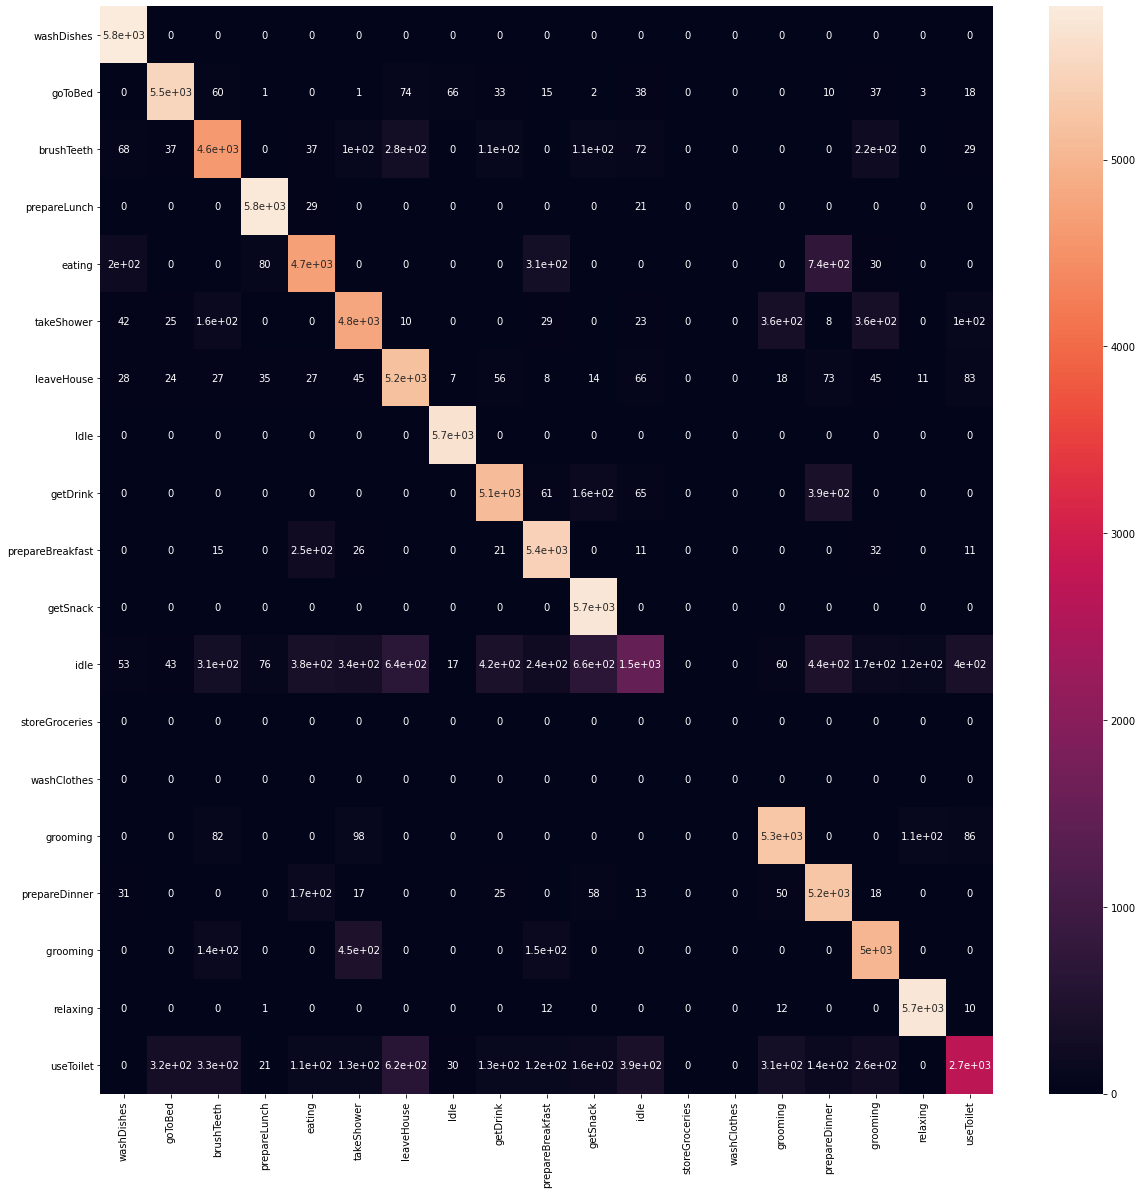

In [44]:
plt.figure(figsize=(20, 20))
sn.heatmap(df_cm_train, annot=True)
# plt.show()
plt.savefig('train_Cf_matrix_allHouse_OneDayValidationFromEachHouse')




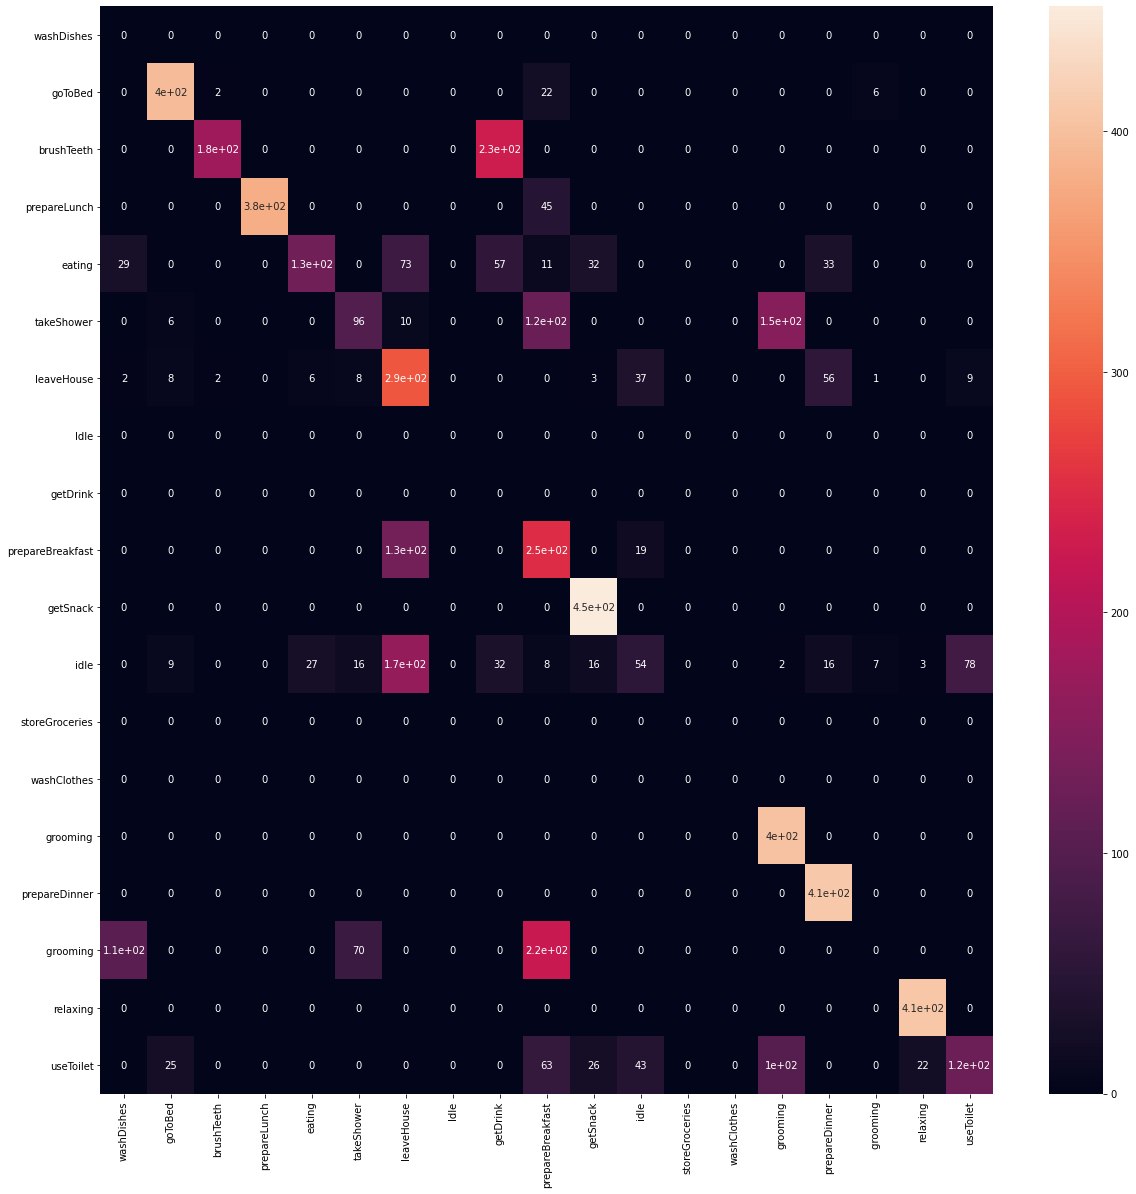

In [46]:
plt.figure(figsize=(20, 20))
sn.heatmap(df_cm_test, annot=True)
# plt.show()
plt.savefig('test_Cf_matrix_allHouse_OneDayValidationFromEachHouse')


In [30]:
total_ids = np.arange(len(labels), dtype=int)
valid_idx = []
valid_idx.extend(total_ids[7183: 8622])
valid_idx.extend(total_ids[37088+4756: 37088+6195])
valid_idx.extend(total_ids[37088 + 20583 + 17353:  37088 + 20583 + 18792])
valid_idx.extend(total_ids[37088 + 20583 + 26488 +11375 : 37088 + 20583 + 26488 +12814])

In [37]:
train_idx = list(set(total_ids) -  set(valid_idx))

In [ ]:
# import time
# import swat
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from time import time



# def getClassnameFromID(train_label):

#     ActivityIdList = config['ActivityIdList']
#     train_label = [x for x in ActivityIdList if x["id"] == int(train_label)]
#     return train_label[0]['name']

# def makeConfigDictionary(labels):
#     config = {}
#     dictList = []
#     for i, name in enumerate(labels):
#         d ={}
#         d['name'] = getClassnameFromID(name)
#         print(d['name'])
#         d['id'] = i
#         dictList.append(d)
#     config['ActivityIdList'] =  dictList
#     return config


# def getClassIdFromname(name):        
#     ActivityIdList = config['ActivityIdList']
#     train_label = [x for x in ActivityIdList  if x["name"] == name]    
#     return train_label[0]['id']

# # Take 10 percent of your data


# label = np.unique(house['activity'].values)

# config = makeConfigDictionary(label)

# print(config)   

# Making T-SNE Plot using house CSV and also using graph embeddings

### Making config values from csv

In [252]:
house = pd.read_csv('../../data/all_houses/graph_embeddings_train.csv')

label = np.unique(house['activity'].values)
config = { "ActivityIdList":
        [{'name': 'washDishes', 'id': 0},
         {'name': 'goToBed', 'id': 1},
         {'name': 'brushTeeth', 'id': 2},
         {'name': 'prepareLunch', 'id': 3},
         {'name': 'eating', 'id': 4},
         {'name': 'takeShower', 'id': 5},
         {'name': 'leaveHouse', 'id': 6},
         {'name': 'getDrink', 'id': 7},
         {'name': 'prepareBreakfast', 'id': 8},
         {'name': 'getSnack', 'id': 9},
         {'name': 'idle', 'id': 10},
         {'name': 'grooming', 'id': 11},
         {'name': 'prepareDinner', 'id': 12},
         {'name': ' grooming', 'id': 13},
         {'name': 'relaxing', 'id': 14},
         {'name': 'useToilet', 'id': 15}]
      }

In [293]:
df = house.iloc[:, 4:]

df['label'] = [x for x in house.loc[-1: , 'activity'].values]

df = df.iloc[:30000]

import time

from sklearn.manifold import TSNE

#n_sne = 7000

time_start = time.time()
tsne = TSNE(n_iter=500, perplexity=30)
tsne_results = tsne.fit_transform(df.values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))



t-SNE done! Time elapsed: 119.8387701511383 seconds


In [294]:
labels

['washDishes',
 'goToBed',
 'brushTeeth',
 'prepareLunch',
 'eating',
 'takeShower',
 'leaveHouse',
 'getDrink',
 'prepareBreakfast',
 'getSnack',
 'idle',
 'grooming',
 'prepareDinner',
 ' grooming',
 'relaxing',
 'useToilet']

In [295]:
np.unique(df['label'].values)

array([ 1,  2,  5,  6,  7,  8,  9, 10, 12, 15])

['washDishes', 'goToBed', 'brushTeeth', 'prepareLunch', 'eating', 'takeShower', 'leaveHouse', 'getDrink', 'prepareBreakfast', 'getSnack', 'idle', 'grooming', 'prepareDinner', ' grooming', 'relaxing', 'useToilet']


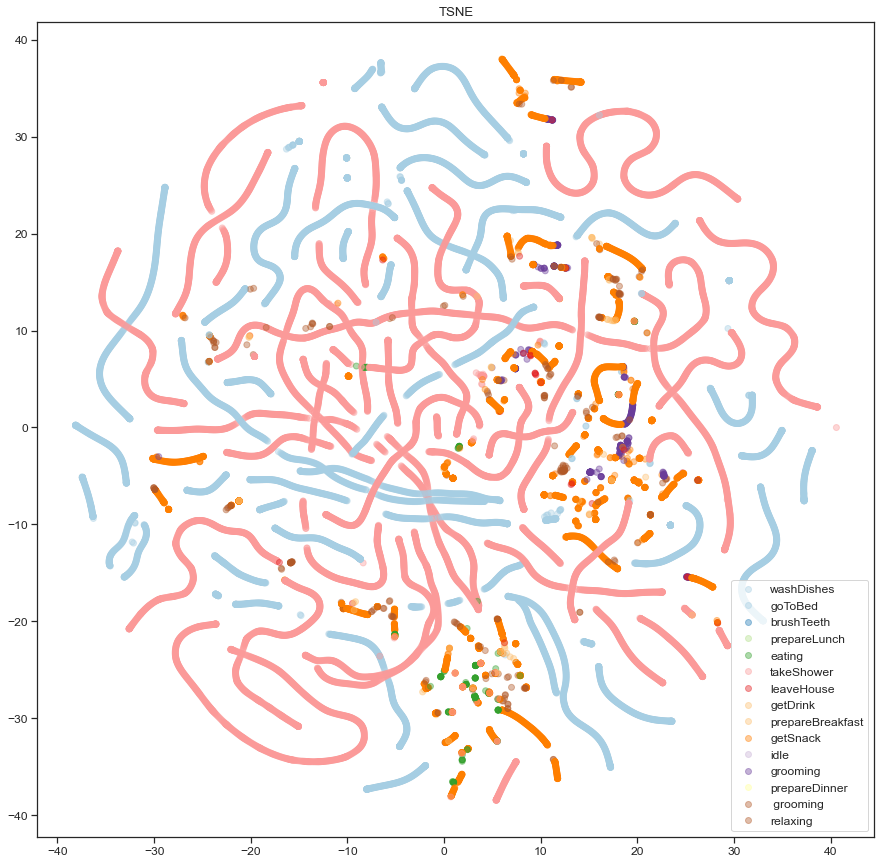

In [296]:
labels = [x['name'] for x in config['ActivityIdList']]
print(labels)

import matplotlib.pyplot as plt
%matplotlib inline
# Create the figure
fig = plt.figure( figsize=(15,15) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
# Create the scatter
scatter = ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1],     
    c=df['label'], 
    cmap=plt.cm.get_cmap('Paired'),     
    alpha=0.4)
handles, _ = scatter.legend_elements()
plt.legend(handles, labels)
plt.savefig('./images/graph_Embeddings_Train_TSNE')

## T-SNE for mnist Using procedure as above, just to check. Seems correct

In [187]:
import torchvision.datasets as dset

In [191]:
train_set = dset.MNIST('./',train=True,  download=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/home/harsh/anaconda3/envs/ds/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [196]:
x_train = []
y_train = []
for i in range(len(train_set)):
    x, y = train_set[i]
    x_train.append(x)
    y_train.append(y)

In [206]:
X = np.zeros((len(x_train), 784))

In [207]:
for i in range(len(train_set)):
    data = np.asarray(x_train[i], dtype="int32")

    X[i] = data.flatten()
    
X = pd.DataFrame(X)


In [208]:
X.shape


(60000, 784)

In [209]:
Y = pd.DataFrame(y_train)

In [210]:
Y.head()

,0
0,5
1,0
2,4
3,1
4,9


In [211]:
X = X.sample(frac=0.1, random_state=10).reset_index(drop=True)
Y = Y.sample(frac=0.1, random_state=10).reset_index(drop=True)
df = X


In [212]:
import time

from sklearn.manifold import TSNE

#n_sne = 7000

time_start = time.time()
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(df.values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 132.3494770526886 seconds


In [213]:
df['label'] = Y

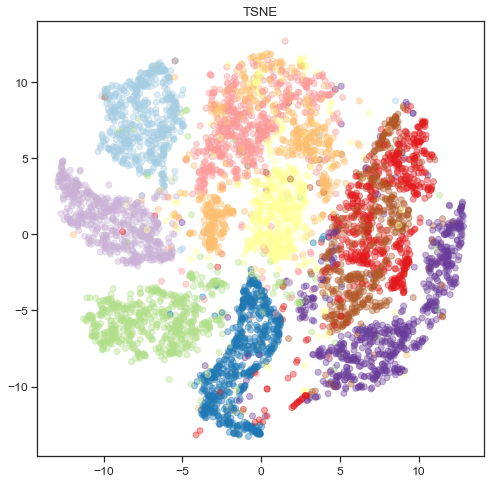

In [215]:
import matplotlib.pyplot as plt
%matplotlib inline
# Create the figure
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
# Create the scatter
ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c=df['label'], 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=0.4)
plt.savefig('./images/MNIST_TSNE')